In [1]:
import sys
sys.path.append('..')
%env WORKDIR ~/Documents/weatherpy-work

env: WORKDIR=~/Documents/weatherpy-work


In [2]:
import pandas as pd
from shapely.geometry import Polygon

def load_chase_alley():
    bdys_df = pd.read_csv('chasealley.csv')
    # depending on the version of shapely, we might have to manually close the polygon
    bdys_df = bdys_df.append(bdys_df.loc[0])
    latlon_mat = bdys_df[['lat', 'lon']].as_matrix()
    return bdys_df, Polygon(latlon_mat)

In [3]:
from wxdata import stormevents

df = stormevents.tornadoes('1996-01-01 00:00', '2017-12-31 23:59', tz='CST',
                          hours=range(12, 24), 
                          months=['April', 'May', 'June'])

/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))


In [4]:
df.columns

Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'magnitude', 'magnitude_type', 'flood_cause', 'category', 'tor_f_scale',
       'tor_length', 'tor_width', 'tor_other_wfo', 'tor_other_cz_state',
       'tor_other_cz_fips', 'tor_other_cz_name', 'begin_range',
       'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth',
       'end_location', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
       'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

In [5]:
bdys_df, chase_alley = load_chase_alley()
chaseable_tors = stormevents.filter_region(df, chase_alley)

In [6]:
chaseable_tors.head()

,begin_yearmonth,begin_day,begin_time,end_yearmonth,end_day,end_time,episode_id,event_id,state,state_fips,...,end_range,end_azimuth,end_location,begin_lat,begin_lon,end_lat,end_lon,episode_narrative,event_narrative,data_source
1,199605,22,1915,199605,22,1920,2033924,5556025,COLORADO,8.0,...,19.0,N,LAIRD,40.37,-102.10,40.37,-102.10,TORNADO TOOK DOWN SEVERAL POWER POLES AND DAMA...,NaN,PDC
3,199605,31,2013,199605,31,2014,2053076,5579344,TEXAS,48.0,...,6.0,E,CLARENDON,34.93,-100.82,34.93,-100.80,ARES Storm Spotters reported a brief tornado t...,NaN,PDC
4,199605,22,1930,199605,22,1930,2035430,5554505,NEBRASKA,31.0,...,2.0,NE,MILFORD,40.78,-97.02,40.78,-97.02,A shed was destroyed 11/4 miles east of Superi...,NaN,PDC
5,199605,31,1817,199605,31,1818,2053066,5579333,TEXAS,48.0,...,5.0,E,CLAUDE,35.12,-101.30,35.12,-101.28,ARES Storm Spotters reported a brief tornado t...,NaN,PDC
6,199606,23,1430,199606,23,1430,2039266,5562050,NEBRASKA,31.0,...,10.0,S,LOUISVILLE,40.85,-96.15,40.85,-96.15,A tornado briefly touched down on Hwy 50 in Ca...,NaN,PDC


In [7]:
len(chaseable_tors)

7227

In [8]:
from wxdata.stormevents import tors
tors_fixed = tors.correct_tornado_times(chaseable_tors)

In [9]:
from wxdata.utils import datetime_buckets

def _buckets_for_single_year(year):
    t1 = pd.Timestamp(year=year, month=4, day=1, hour=0, minute=0)
    t2 = pd.Timestamp(year=year, month=7, day=1, hour=0, minute=0)
    return datetime_buckets(t1, t2, '1 day', tz='CST')

def buckets_for_years(years):
    from itertools import chain
    all_buckets = (_buckets_for_single_year(year) for year in years)
    return chain.from_iterable(all_buckets)

In [10]:
from wxdata.extras import timebucketed_clusters
raw_clusters = timebucketed_clusters(tors_fixed, buckets_for_years(range(1996, 2018)), 
                                    eps_km=80, eps_min=60, min_samples=10)

In [11]:
def aggregated(clusts):
    ret = pd.DataFrame()
    
    def get_biggest(row):
        row_cluster = clusts[row.dummy]
        if not row_cluster:
            return 0
        return len(row_cluster.biggest_cluster())
    
    ret['dummy'] = list(clusts.keys())
    ret['clust_dates'] = [k[0] for k in clusts.keys()]
    ret['year'] = ret['clust_dates'].dt.year
    ret['month'] = ret['clust_dates'].dt.month
    ret['day'] = ret['clust_dates'].dt.day
    ret['size'] = ret.apply(lambda r: clusts[r.dummy].numpoints(), axis=1)
    ret['biggest'] = ret.apply(get_biggest, axis=1)
    ret.drop('dummy', axis=1, inplace=True)
    return ret

In [12]:
clusts_by_date = aggregated(raw_clusters)

In [167]:
clusts_by_date.sort_values('biggest', ascending=False).head(10)

,clust_dates,year,month,day,size,biggest
305,1999-05-03 00:00:00-06:00,1999,5,3,798,629
1144,2008-05-23 00:00:00-06:00,2008,5,23,920,449
1873,2016-05-24 00:00:00-06:00,2016,5,24,320,305
1418,2011-05-24 00:00:00-06:00,2011,5,24,399,293
280,1999-04-08 00:00:00-06:00,1999,4,8,324,273
1034,2007-05-04 00:00:00-06:00,2007,5,4,305,270
1469,2012-04-14 00:00:00-06:00,2012,4,14,856,260
1445,2011-06-20 00:00:00-06:00,2011,6,20,306,258
670,2003-05-04 00:00:00-06:00,2003,5,4,446,256
1764,2015-05-06 00:00:00-06:00,2015,5,6,437,239


In [227]:
def dayofyear_aggregate(df, dummy_year=2017):
    clust_distr = df.groupby(['month', 'day']).count().reset_index()[['month', 'day', 'clust_dates']]
    clust_distr['date'] = clust_distr.apply(
        lambda r: pd.Timestamp(year=dummy_year, month=r.month, day=r.day), 
        axis=1)

    fills = pd.DataFrame(columns=['month', 'day', 'clust_dates', 'date'])
    from datetime import date
    for fill_start, fill_end in buckets_for_years([dummy_year]):
        to_date = pd.Timestamp(year=fill_start.year, month=fill_start.month, 
                               day=fill_start.day).to_datetime64()

        if to_date not in clust_distr.date.values:
            row = {
                'month': fill_start.month,
                'day': fill_start.day,
                'clust_dates': 0,
                'date': to_date
            }
            fills.loc[len(fills)] = row

    clust_distr = pd.concat([clust_distr, fills])
    clust_distr.sort_values('date', inplace=True)
    return clust_distr

def by_range(df, lower, upper=None):
    if upper is None:
        biggest_clusts = df[df['biggest'] >= lower]
    else:
        biggest_clusts = df[(df['biggest'] >= lower) & (df['biggest'] < upper)]
    return biggest_clusts

def chunk_biggest_by_range(df, lower, upper=None):
    return dayofyear_aggregate(by_range(df, lower, upper))

In [234]:
small = chunk_biggest_by_range(clusts_by_date, 15, 30)
medium = chunk_biggest_by_range(clusts_by_date, 30, 60)
large = chunk_biggest_by_range(clusts_by_date, 60, 120)
xlarge = chunk_biggest_by_range(clusts_by_date, 120)
all_ = chunk_biggest_by_range(clusts_by_date, 15, 9999)

xlarge_mat = xlarge['clust_dates'].as_matrix()
large_mat = large['clust_dates'].as_matrix()
medium_mat = medium['clust_dates'].as_matrix()
small_mat = small['clust_dates'].as_matrix()

In [122]:
# specific = clusts_by_date[(clusts_by_date['biggest'] >= 60) & 
#                (clusts_by_date['biggest'] < 9999) & 
#                (clusts_by_date['month'] == 6) &
#                (clusts_by_date['day'].isin(range(4, 18)))].sort_values(['year', 'day'], ascending=[False, True])

# specific

In [123]:
large.sort_values('clust_dates', ascending=False).head(10)

,month,day,clust_dates,date
22,5,25,5,2017-05-25
21,5,24,4,2017-05-24
17,5,16,3,2017-05-16
20,5,22,3,2017-05-22
27,6,4,3,2017-06-04
3,4,16,2,2017-04-16
25,5,31,2,2017-05-31
13,5,10,2,2017-05-10
12,5,9,2,2017-05-09
29,6,7,2,2017-06-07


In [124]:
xlarge.sort_values('clust_dates', ascending=False).head(10)

,month,day,clust_dates,date
20,5,24,3,2017-05-24
22,5,29,2,2017-05-29
19,5,23,2,2017-05-23
18,5,22,2,2017-05-22
17,5,19,2,2017-05-19
8,5,4,2,2017-05-04
29,6,17,2,2017-06-17
5,4,29,1,2017-04-29
11,5,7,1,2017-05-07
25,6,9,1,2017-06-09


In [125]:
def moving_sum(df, numdays):
    barebones = df[['date', 'clust_dates']].sort_values('date')
    barebones.set_index('date', inplace=True)
    window = str(numdays) + 'd'
    movingsum = barebones.rolling(window=window, min_periods=numdays).sum()
    return movingsum[~movingsum.clust_dates.isna()]

In [126]:
def bar_for(ax, size_groupings, color, bottom=None, alpha=1, width=1):
    return ax.bar(size_groupings['date'], size_groupings['clust_dates'], 
                  color=color, width=width, bottom=bottom, alpha=alpha)

def movingline_for(ax, size_groupings, window_days, color, 
                   alpha=1, linewidth=2.5, linestyle='-'):
    line = moving_sum(size_groupings, window_days)
    plot = ax.plot(line, color=color, linewidth=linewidth, linestyle=linestyle)
    return plot

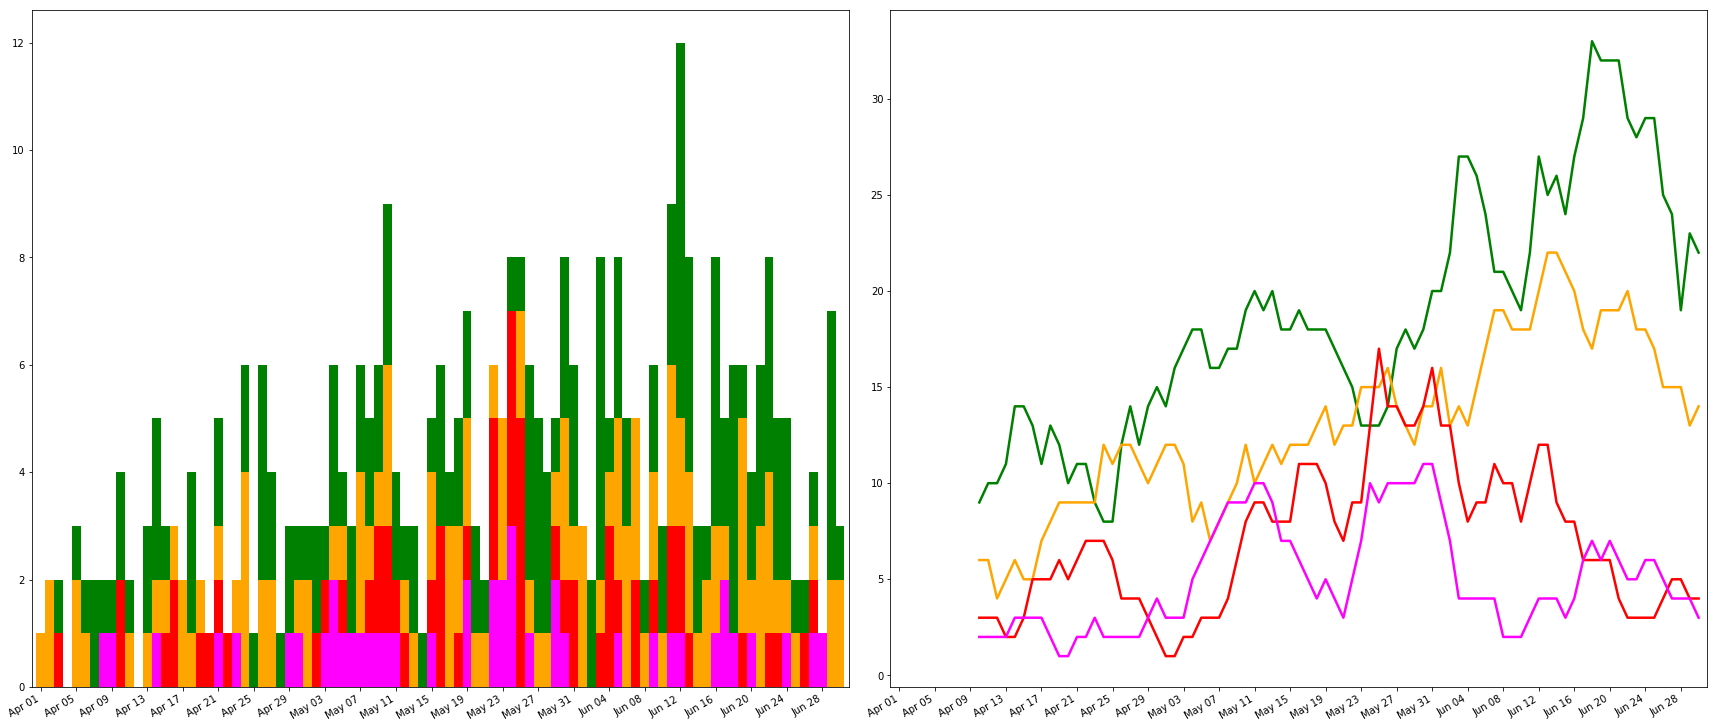

In [127]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(24, 12))
plt.tight_layout()

bar_for(ax, xlarge, 'magenta')
bar_for(ax, large, 'red', bottom=xlarge_mat)
bar_for(ax, medium, 'orange', bottom=large_mat + xlarge_mat)
bar_for(ax, small, 'green', bottom=medium_mat + large_mat + xlarge_mat)

window_days = 10
movingline_for(ax2, small, window_days, 'green')
movingline_for(ax2, medium, window_days, 'orange')
movingline_for(ax2, large, window_days, 'red')
movingline_for(ax2, xlarge, window_days, 'magenta')


datemin = date(2017, 3, 31)
datemax = date(2017, 7, 1)
ax.set_xlim(datemin, datemax)

for ax in (ax, ax2):
    ax.set_xlim(datemin, datemax)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

fig.autofmt_xdate()

In [154]:
from wxdata.plotting import top_left_textbox

def plot_max_cluster_data(data, color, title):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24, 10))
    plt.tight_layout()

    bar_for(ax1, data, color, width=1)

    window_days = {
        7: ':',
        14: '-',
        21: '--'
    }

    lines = []
    for days in window_days:
        style = window_days[days]
        line = movingline_for(ax2, data, window_days=days, color=color, linewidth=2.5, linestyle=style)
        lines.append(line)

    for ax in (ax1, ax2):
        ax.set_xlim(datemin, datemax)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.grid(linewidth=1, alpha=0.25)

    fig.autofmt_xdate()
    
    ax1.set_title('Raw Counts', fontsize='x-large')
    ax2.set_title('Moving Sum', fontsize='x-large')
    
    ax2.legend(lines, loc=2, labels=['{}-day'.format(days) for days in window_days], fontsize='large')
    
    plt.figtext(0.5, 0.935,'Graphic by Jim Tang (@wxmann)', va='center', ha='center', size=18)
    actual_title = '{} [{}]'.format(title, '1996-2017')
    plt.suptitle(actual_title, fontsize=21)
    plt.subplots_adjust(top=0.91)
    
    return fig, (ax1, ax2)

/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/site-packages/matplotlib/legend.py:1357: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


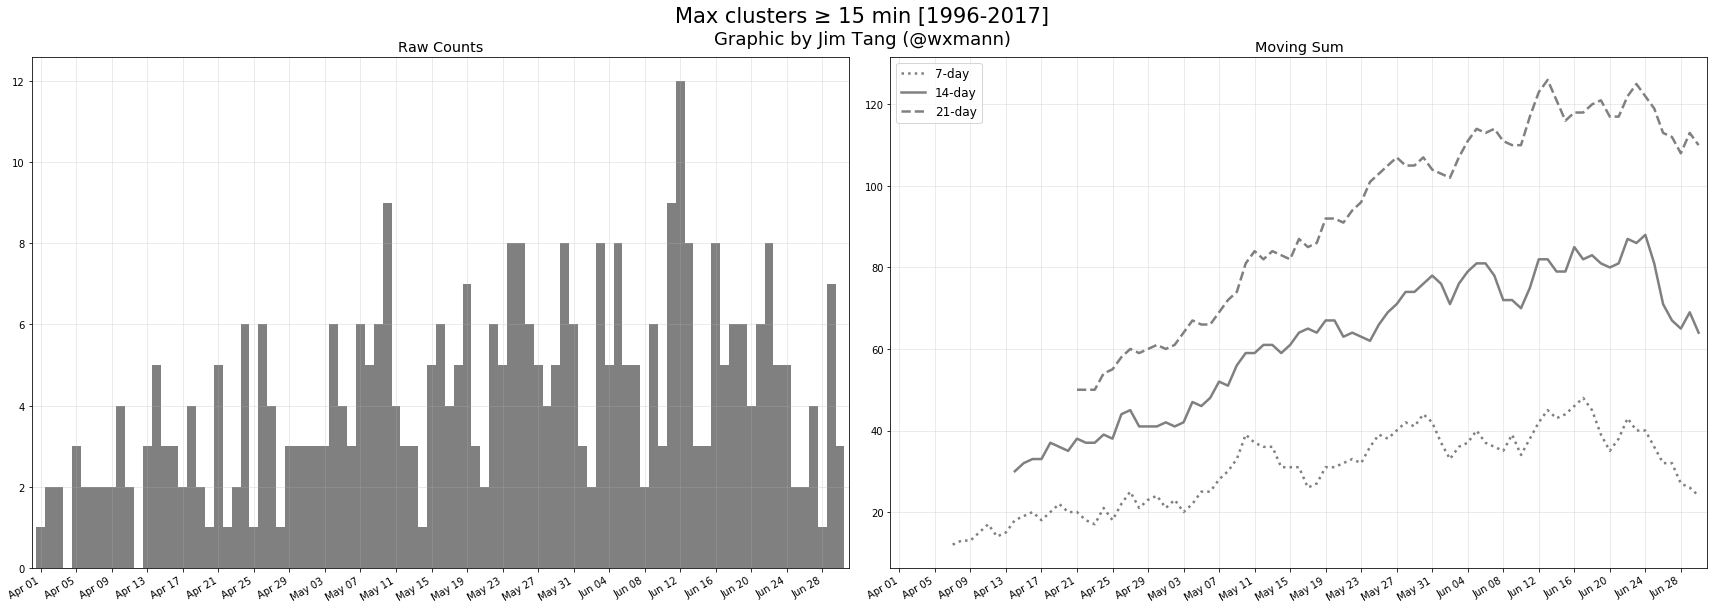

In [235]:
fig, _ = plot_max_cluster_data(all_, 'gray', 'Max clusters ≥ 15 min')

/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/site-packages/matplotlib/legend.py:1357: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


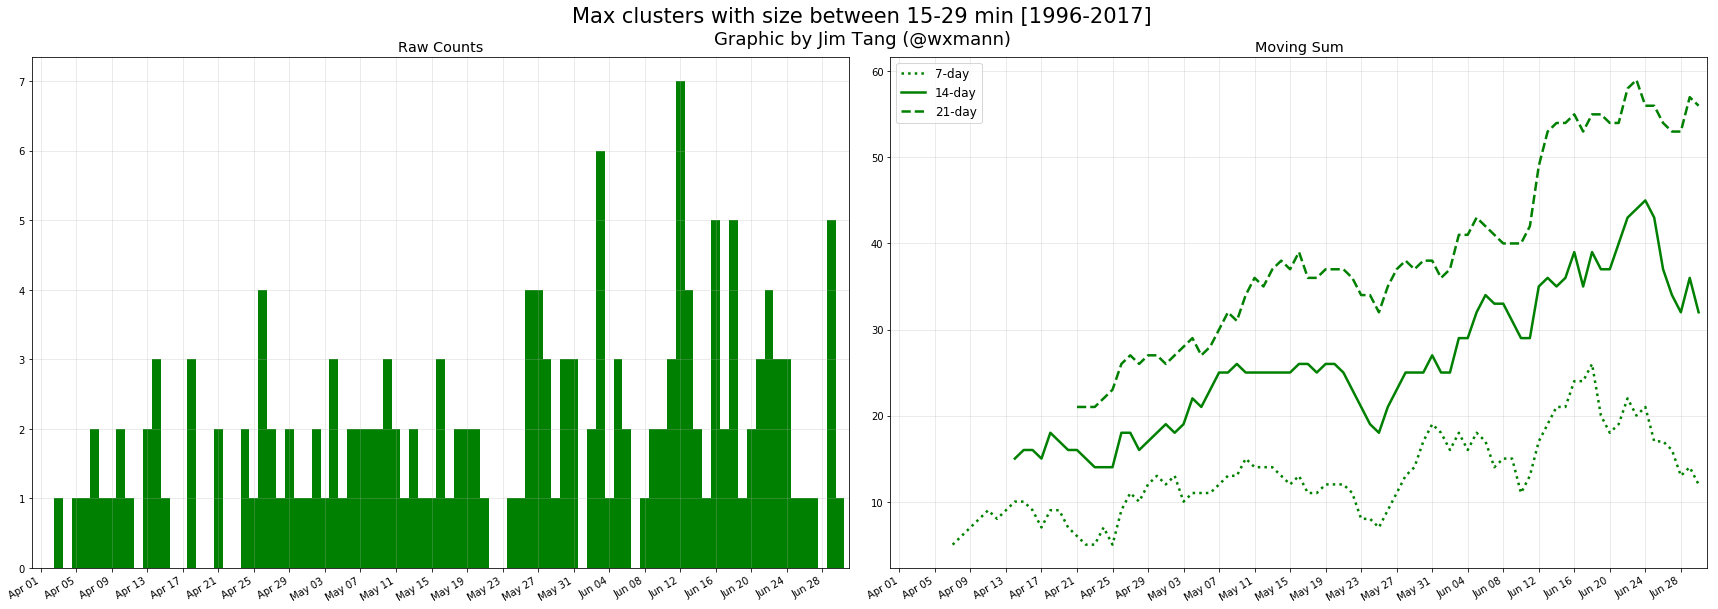

In [239]:
fig, _ = plot_max_cluster_data(small, 'green', 'Max clusters with size between 15-29 min')

/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/site-packages/matplotlib/legend.py:1357: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


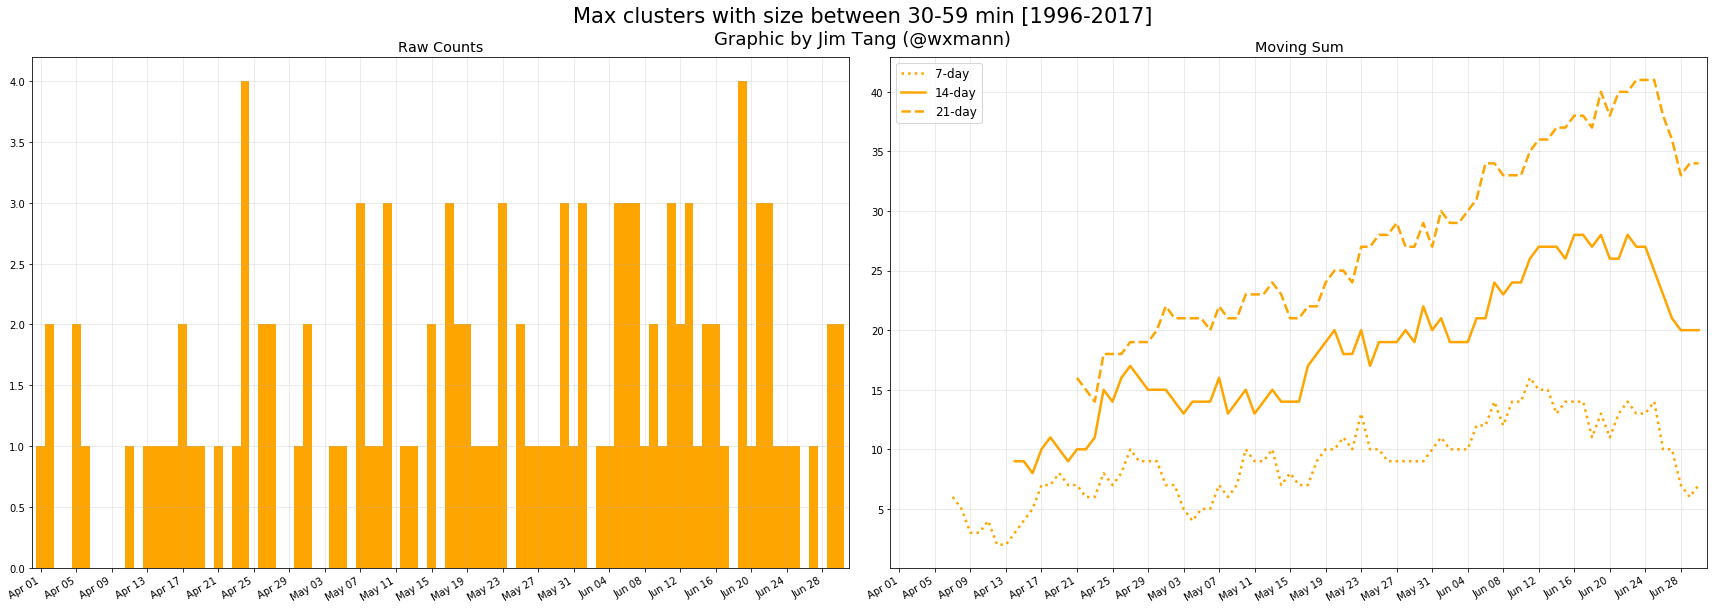

In [241]:
fig, _ = plot_max_cluster_data(medium, 'orange', 'Max clusters with size between 30-59 min')

/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/site-packages/matplotlib/legend.py:1357: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


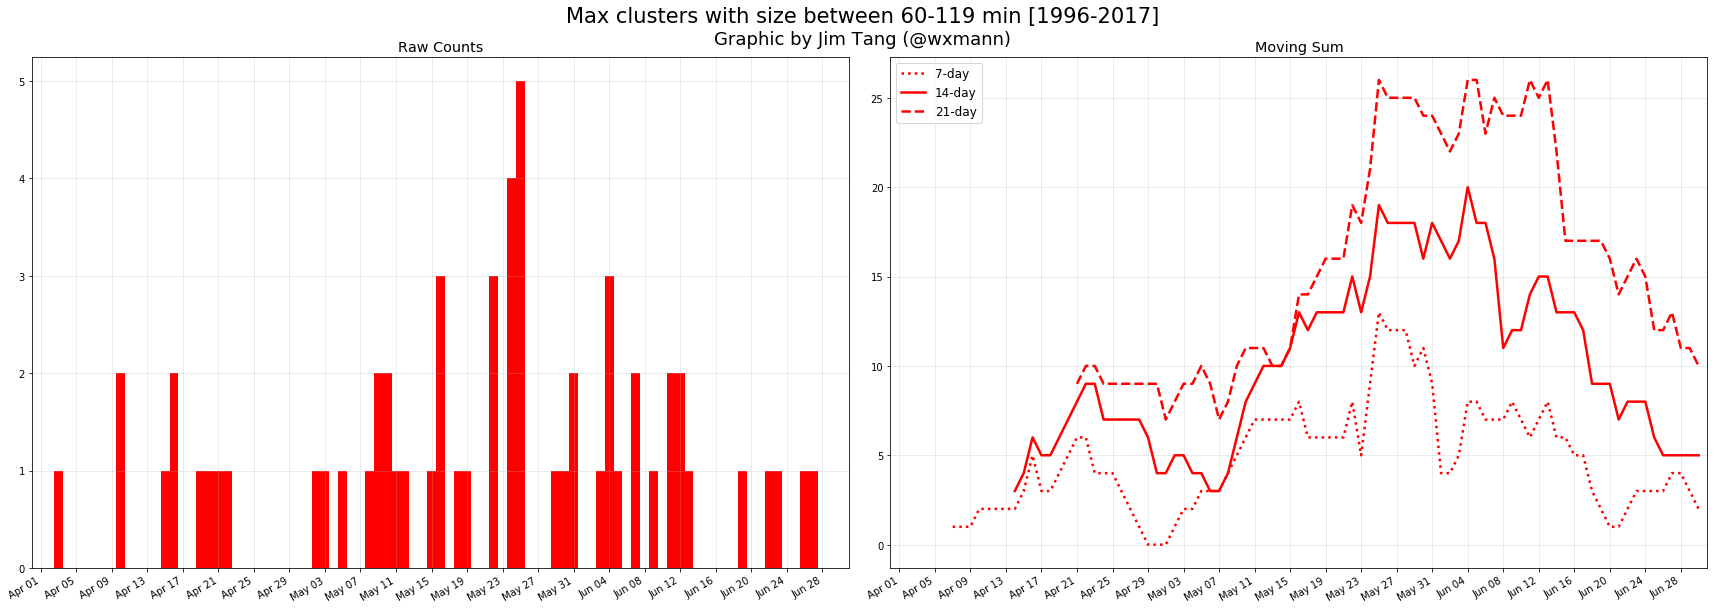

In [243]:
fig, _ = plot_max_cluster_data(large, 'red', 'Max clusters with size between 60-119 min')

/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/site-packages/matplotlib/legend.py:1357: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


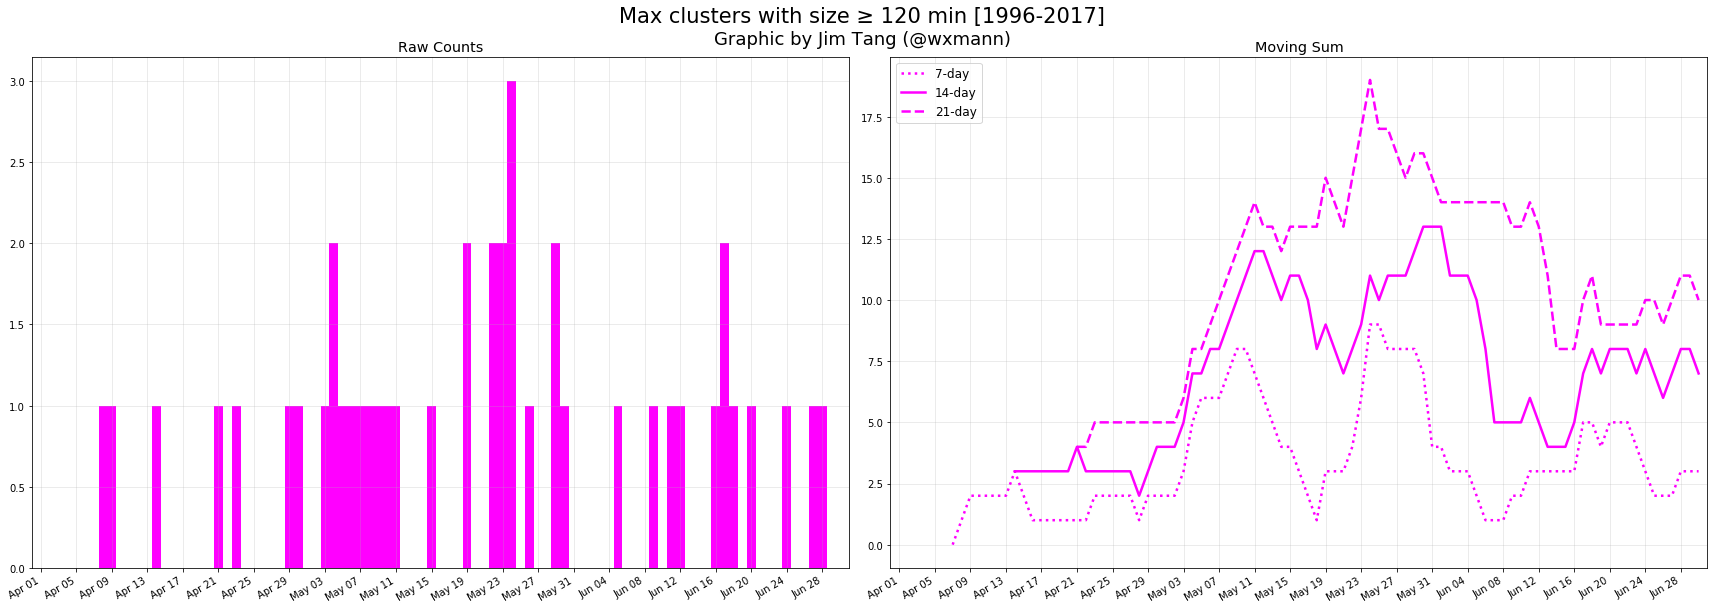

In [245]:
fig, _ = plot_max_cluster_data(xlarge, 'magenta', 'Max clusters with size ≥ 120 min')

/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/site-packages/matplotlib/legend.py:1357: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


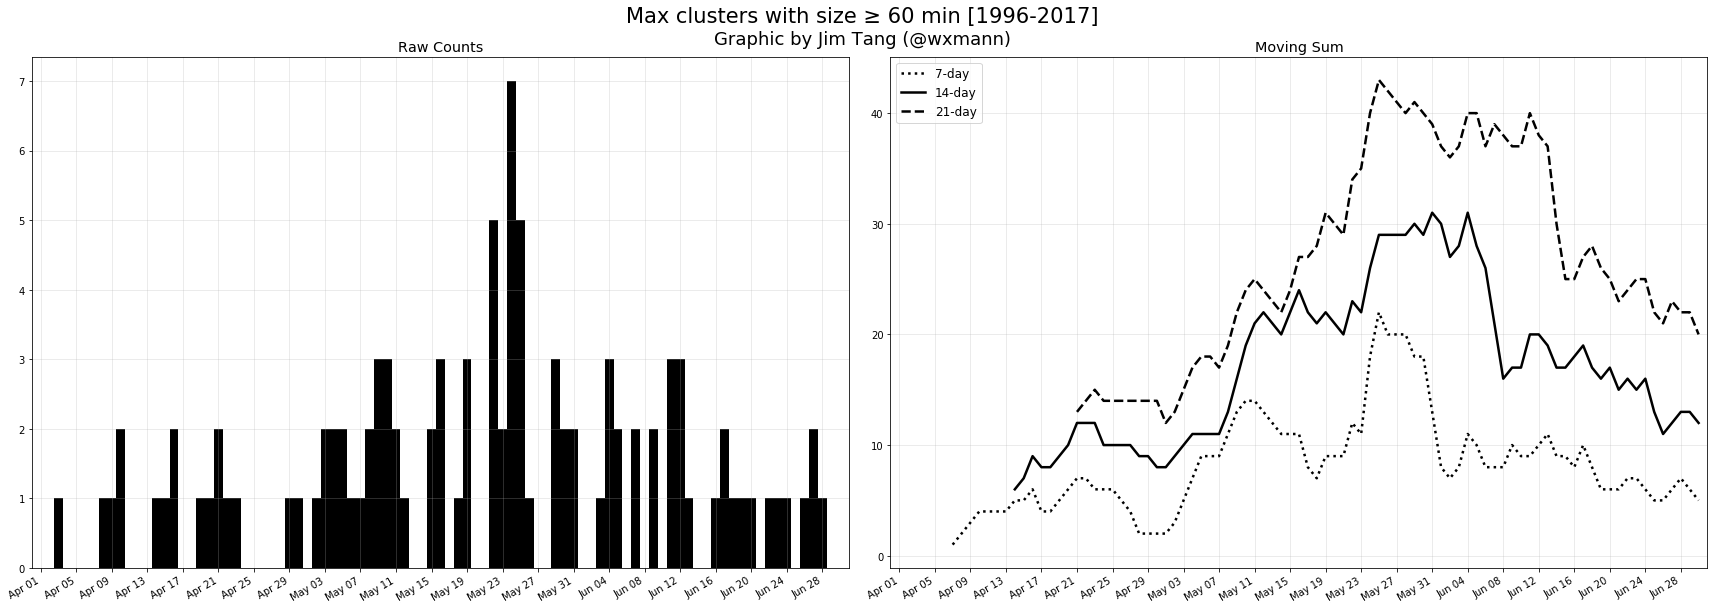

In [247]:
bigger_threshold = 60
bigger = chunk_biggest_by_range(clusts_by_date, bigger_threshold, 9999)
fig, _ = plot_max_cluster_data(bigger, 'black', 'Max clusters with size ≥ {} min'.format(bigger_threshold))

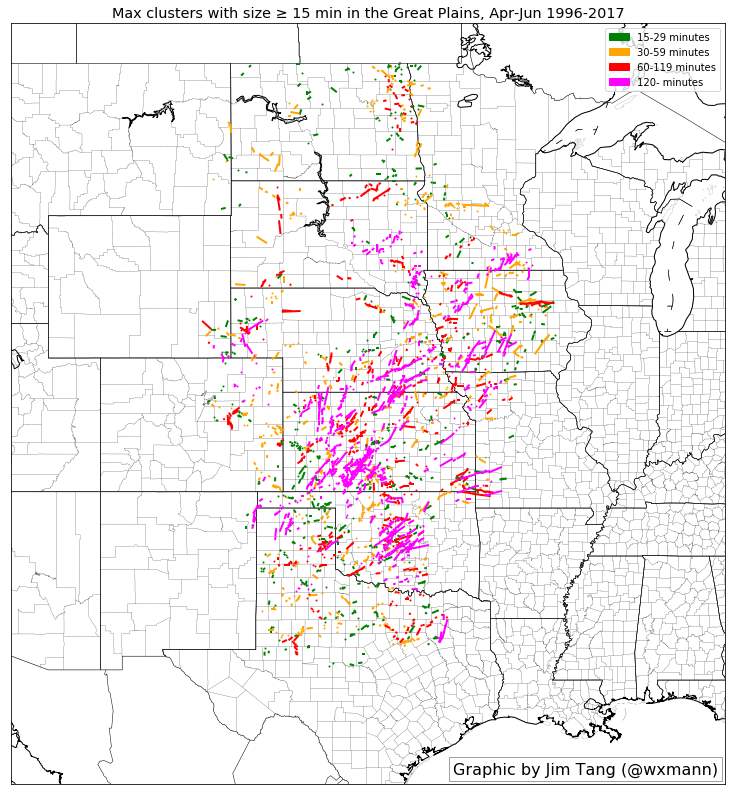

In [254]:
from wxdata.plotting import simple_basemap

fig = plt.figure(figsize=(14, 14))
m = simple_basemap(bbox=(-112.5, -85, 27.5, 50), proj='merc', 
                   draw=('coastlines', 'countries', 'states', 'counties'))

smallt = by_range(clusts_by_date, 15, 30)
mediumt = by_range(clusts_by_date, 30, 60)
larget = by_range(clusts_by_date, 60, 120)
xlarget = by_range(clusts_by_date, 120)

ranges = {
    (15, 30): (smallt, 'green'),
    (30, 60): (mediumt, 'orange'),
    (60, 120): (larget, 'red'),
    (120, 9999): (xlarget, 'magenta')
}

def plot_clusts_on_map(clusts, color):
    for _, row in clusts.iterrows():
        date_ = row['clust_dates']
        pd_date = pd.Timestamp(date_)
        daterange = (pd_date, pd_date + pd.Timedelta('1 day'))

        biggest_clust = raw_clusters[daterange].biggest_cluster()
        tors.plot_tornadoes(biggest_clust.events, m, color=color, linewidth=2)

import matplotlib.patches as mpatches
legend_handles = []

for range_ in ranges:
    clusts, color = ranges[range_]
    
    label = '{}-{} minutes'.format(range_[0], range_[1] - 1 if range_[1] < 9999 else '')
    patch = mpatches.Patch(color=color, label=label)
    legend_handles.append(patch)
    
    plot_clusts_on_map(clusts, color)

from wxdata.plotting import bottom_right_textbox, bottom_left_textbox
plt.legend(handles=legend_handles)
plt.title('Max clusters with size ≥ 15 min in the Great Plains, Apr-Jun 1996-2017', fontsize='x-large')
bottom_right_textbox(plt.gca(), 'Graphic by Jim Tang (@wxmann)')